# A Deep Learning Heteroscedastic Uncertainty Approach to Fault Detection of Wind Turbines using SCADA data 

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import tensorflow.keras as keras
import scipy.stats as stats
import math
# from rate import *

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from math import sqrt

# from tensorflow.keras.layers import TimeDistributed, Attention, Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization, Concatenate
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import plot_model

# from keras.layers import Input, Dense, Dropout
# from keras.models import Model, Sequential
# from keras.utils import plot_model
# from tensorflow.keras.optimizers import RMSprop, Adam
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow_probability import distributions as tfd
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import FuncFormatter

#### Auxiliary Functions

In [13]:
def plot_means_variances(y_true, y_means, y_stddevs):
    plt.rc('font', size=14)
    min_vals = np.min([np.min(y_true), np.min(y_means)])
    max_vals = np.max([np.max(y_true), np.max(y_means)])

    plt.figure(figsize=(16, 6))

    # Plot predicted vs true
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_means, alpha = .7, color="0.3", linewidth = 0, s = 2)
    plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line
    plt.title('Fig (a): Predicted vs True Values')
    plt.xlabel('True Power Output')
    plt.ylabel('Predicted Power Output')
    
    def plot_binned_residuals(y_true, residuals, num_bins=20):
        bins = np.linspace(min(y_true), max(y_true), num_bins + 1)

        bin_means = [0]*num_bins
        bin_stddevs = [0]*num_bins

        for i in range(num_bins):
            mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
            if np.any(mask):
                bin_means[i] = np.mean(y_true[mask])
                bin_stddevs[i] = np.sqrt(mean_squared_error(y_means[mask], y_true[mask]))
        return bin_means, bin_stddevs

    bin_means, bin_stddevs = plot_binned_residuals(y_true, y_means, num_bins=20)
    
    # Plot residuals vs true
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_stddevs, alpha = .7, color="0.3", linewidth = 0, s = 2, label='Predicted Standard Deviation', zorder=1)
    plt.scatter(bin_means, bin_stddevs, alpha=1, s=50, color='red', label='True Binned Root Mean Squared Error', zorder=2)
    plt.title('Fig (b): Predicted Standard Deviation vs True RMSE')
    plt.xlabel('True Power Output')
    plt.ylabel('Predicted Standard Deviation')
    plt.legend()


    plt.tight_layout()
    plt.show()

    
def evaluate_and_print_metrics(results, model_name, y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)    # in %
    test_mae = mean_absolute_error(y_test, y_test_pred)       # in %

    train_lower_bound = y_train_pred - z_value * y_train_stddevs
    train_upper_bound = y_train_pred + z_value * y_train_stddevs

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    train_within_interval = np.sum(np.logical_and(y_train.ravel() >= train_lower_bound, y_train.ravel() <= train_upper_bound))
    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    train_percentage_within_interval = (train_within_interval / len(y_train.ravel())) * 100
    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

   
    results[model_name] = {
        "Test Root Mean Squared Error (RMSE): ": test_rmse,
        "Test Mean Absolute Error (MAE): ": test_mae,
        f"Percentage of Test Data Points within {ci*100:.2f}% CI: ": test_percentage_within_interval
    }

    print(f"Train RMSE: {train_rmse:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f}")
    print(f"Percentage of Train Data Points within {ci*100:.2f}% CI: {train_percentage_within_interval:.2f}%")
    print(f"Percentage of Test Data Points within {ci*100:.2f}% CI: {test_percentage_within_interval:.2f}%")

def plot_confidence_interval_scatter(y_test_pred, y_test_std, y_test, bins=20):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])

    percentages_within_interval = []
    for t_value in t_values:
        lower_bounds = y_test_pred.ravel() - t_value * y_test_std
        upper_bounds = y_test_pred.ravel() + t_value * y_test_std

        # Count number of data points within the confidence interval
        is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
        num_within_interval = np.sum(is_within_interval)

        # Calculate the percentage of data points within the confidence interval
        percentage_within_interval = (num_within_interval / len(y_test)) * 100
        percentages_within_interval.append(percentage_within_interval)

    plt.figure(figsize=(8, 8))
    plt.scatter(np.arange(1, bins+1)*100/bins, percentages_within_interval, color='blue', label='Percentage of Residuals within Interval')
    
    # Plot the expected diagonal line (red line)
    plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Expected')

    # Add percentage symbols to x-axis ticks
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))

    plt.xlabel('Confidence Intervals')
    plt.ylabel('Percentage within Interval')
    plt.title('Scatter Plot of Percentage of Residuals within the Confidence Intervals')
    plt.legend()

    plt.show()
    
def load_dataset_train_test_split(df, features, output_feature):
    keras.utils.set_random_seed(812)
    X = df[features]
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Scale input data to facilitate training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, np.array(y_train), np.array(y_test), scaler
    
def train_model(model, X_train, y_train, patience, epochs, batch_size, cp_callback):
    tf.random.set_seed(MODELS_SEED)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, cp_callback])
    return history

def plot_loss_history(history):
    plt.plot(history.history['loss'][1:], label='Training Loss')
    plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def compute_predictions(model, X_train, X_test, num_samples=100):
    y_train_pred = []
    y_test_pred = []
    for _ in range(num_samples):
        y_train_pred.append(model.predict(X_train))
        y_test_pred.append(model.predict(X_test))
        
    y_train_pred = np.concatenate(y_train_pred, axis=1)
    y_test_pred = np.concatenate(y_test_pred, axis=1)

    y_train_pred_mean = np.mean(y_train_pred, axis=1)
    y_train_pred_stddevs = np.std(y_train_pred, axis=1)
    
    y_test_pred_mean = np.mean(y_test_pred, axis=1)
    y_test_pred_stddevs = np.std(y_test_pred, axis=1)
    
    return y_train_pred_mean, y_train_pred_stddevs, y_test_pred_mean, y_test_pred_stddevs

def NLL(y, distr): 
    return -distr.log_prob(y) 

# We add 0.001 to the standard deviation to ensure it does not converge to 0 and destabilizes training because the gradient
# of maximum likelihood estimation requires the inversion of the variance. We also activate the parameters using a softplus
# activation function to enfore a positive standard deviation estimate.
def normal_softplus(params): 
    return tfd.Normal(loc=params[:, 0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))

def multivariate_covariance_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalTriL(loc=means, scale_tril=tfp.math.fill_triangular(stds))

def multivariate_diagonal_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    
    return tfd.MultivariateNormalDiag(loc=means, scale_diag=stds)

## Data Analysis

In [8]:
# In order to ensure that each model has repeatable results,we fix the seed both for the
# data splitting part and for the initilialization of the networks' weights. Theoretially
# speaking, we should average over different seeds to ensure the robustness of our results.
# However, in practice, due to the size of the data set this is unfeasibile and we only do
# this for the best performing model to show that the variability of results based on seed
# is almost none.

keras.utils.set_random_seed(812)
MODELS_SEED = 42

In [9]:
file_path = 'Cleaned_data.pkl'
df_full = pd.read_pickle(file_path)

In [10]:
df_full.shape

(1018494, 110)

In [11]:
# Datetime column
DATETIME_COL = 'Date.time'

units = {
'Wind.speed.me': 'm/s',
'Wind.speed.sd': 'm/s', 
'Wind.speed.min': 'm/s',
'Wind.speed.max': 'm/s',
'Front.bearing.temp.me': '°C',
'Front.bearing.temp.sd': '°C',
'Front.bearing.temp.min': '°C',
'Front.bearing.temp.max': '°C',
'Rear.bearing.temp.me': '°C',
'Rear.bearing.temp.sd': '°C',
'Rear.bearing.temp.min': '°C',
'Rear.bearing.temp.max': '°C',
'Rotor.bearing.temp.me': '°C',
'Stator1.temp.me': '°C',
'Nacelle.ambient.temp.me': '°C',
'Nacelle.temp.me': '°C',
'Transformer.temp.me': '°C',
'Gear.oil.temp.me': '°C',
'Gear.oil.inlet.temp.me': '°C',
'Top.box.temp.me': '°C',
'Hub.temp.me': '°C',
'Conv.Amb.temp.me': '°C',
'Rotor.bearing.temp.me': '°C',
'Transformer.cell.temp.me': '°C',
'Motor.axis1.temp.me': '°C',
'Motor.axis2.temp.me': '°C',
'CPU.temp.me': '°C',
'Blade.ang.pitch.pos.A.me': '°',
'Blade.ang.pitch.pos.B.me': '°',
'Blade.ang.pitch.pos.C.me': '°',
'Gear.oil.inlet.press.me': 'bar',
'Gear.oil.pump.press.me': 'bar',
'Drive.train.acceleration.me': 'mm/s^2',
'Tower.Acceleration.x': 'mm/s^2',
'Tower.Acceleration.y': 'mm/s^2'
}

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.inlet.temp.me',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'

# Only consider the turbine with ID 5
TURBINE_ID = 5
df = df_full[df_full['turbine'] == TURBINE_ID]
print(f"Total data points for turbine {TURBINE_ID} before removing NaNs: ", len(df))
df = df.dropna(subset=features + [output_feature] + [DATETIME_COL])
print(f"Total data points for turbine {TURBINE_ID} after removing NaNs: ", len(df))
df = df.reset_index(drop=False) 

Total data points for turbine 5 before removing NaNs:  191579
Total data points for turbine 5 after removing NaNs:  189381


In [7]:
df.head()

,index,Date.time,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,...,Blade.ang.pitch.pos.C.sd,Blade.ang.pitch.pos.C.min,Blade.ang.pitch.pos.C.max,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year
0,778652,2017-09-25 00:00:00,170.785782,18.711275,117.633080,201.376236,178.246281,4.758976,0.470051,3.839334,...,NaN,NaN,NaN,76.154892,329.839172,47.446136,34.605957,12.856477,5,2017
1,778653,2017-09-25 00:10:00,196.361282,29.352943,132.657440,244.603409,214.993427,5.053728,0.455439,4.297034,...,NaN,NaN,NaN,78.530861,337.024353,45.788548,24.391794,12.387291,5,2017
2,778654,2017-09-25 00:20:00,213.066101,18.548962,175.467987,244.880829,186.659122,4.834767,0.438846,3.727230,...,NaN,NaN,NaN,78.428474,335.595490,44.958530,19.414160,14.047290,5,2017
3,778655,2017-09-25 00:30:00,180.647583,16.838543,143.989594,220.636795,194.940699,4.909376,0.403833,3.910666,...,NaN,NaN,NaN,72.759590,318.466614,45.136253,21.682341,11.815598,5,2017
4,778656,2017-09-25 00:40:00,201.553589,11.615179,178.872192,223.635696,182.866606,4.800600,0.485835,4.098299,...,NaN,NaN,NaN,73.908447,320.857849,44.799519,21.100346,11.945602,5,2017


In [8]:
descriptive_stats = df[features + [output_feature]].describe()
pd.set_option('display.max_columns', None)
display(descriptive_stats)

,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,Rear.bearing.temp.sd,Rear.bearing.temp.min,Rear.bearing.temp.max,Rotor.bearing.temp.me,Stator1.temp.me,Nacelle.ambient.temp.me,Nacelle.temp.me,Transformer.temp.me,Gear.oil.temp.me,Gear.oil.inlet.temp.me,Top.box.temp.me,Hub.temp.me,Conv.Amb.temp.me,Transformer.cell.temp.me,Motor.axis1.temp.me,Motor.axis2.temp.me,CPU.temp.me,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.C.me,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,Power.me
count,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000,189381.000000
mean,6.061792,0.929598,4.285672,7.826800,65.249559,0.611390,64.235198,66.234087,63.228148,0.665511,62.131779,64.294001,25.147016,62.680004,10.395775,19.545742,48.827492,52.035799,48.283892,24.561808,20.016075,14.146877,16.435012,42.007367,42.461620,53.257354,4.664098,4.664053,4.664393,118.197068,459.291346,21.301466,57.177760,27.941015,624.587598
std,2.767883,0.461186,2.206099,3.482993,10.096854,0.504141,9.916454,10.287366,8.592414,0.576825,8.409253,8.819052,3.963058,7.853748,5.895684,5.386682,19.850288,5.862262,8.085823,3.431033,4.873869,6.028698,5.922955,18.629214,18.868266,3.212041,12.673886,12.673785,12.674054,54.677459,164.758023,36.644667,30.554552,15.813479,631.196896
min,0.129863,0.000000,-0.444250,0.243750,14.565001,0.000000,14.400000,14.600000,13.147500,0.000000,13.100000,13.200000,9.002500,13.720000,-6.800000,1.245000,18.690001,13.857500,9.235000,9.520000,7.762000,-2.642500,-1.037500,10.400000,11.000000,38.000000,0.000000,0.000000,0.000000,-4.160219,5.963073,3.013230,1.225289,2.458500,-21.170280
25%,4.052706,0.595049,2.674919,5.362026,61.002500,0.236114,60.099998,61.900002,61.092499,0.240885,60.400002,61.849998,22.215000,59.665001,6.020000,15.917500,35.562500,49.326313,42.110000,22.900000,16.043158,9.677500,11.925000,27.074500,28.000000,52.000000,0.000000,0.000000,0.000000,83.152820,352.544764,4.978957,36.144118,17.303601,122.224066
50%,5.707567,0.851638,4.071932,7.317771,69.794736,0.475730,68.449997,70.900002,66.140001,0.477723,65.050003,67.000000,25.049999,62.027500,9.690000,19.530000,42.087499,53.122500,50.200000,24.920000,19.000000,13.590000,16.092500,36.849998,37.124000,53.525002,0.026500,0.026500,0.026500,98.062714,404.299846,7.397583,54.777193,25.706060,382.674857
75%,7.657582,1.180467,5.618109,9.794380,72.277500,0.845470,71.199997,73.300003,68.575001,0.928453,67.199997,70.000000,28.059524,64.492499,14.352500,23.075000,54.002631,56.322498,55.132500,26.395000,23.196500,18.242500,20.514999,54.286500,54.245499,55.000000,1.116000,1.116000,1.117000,151.218739,564.198951,14.488859,77.716939,35.893112,967.920566
max,22.151195,5.016237,17.995665,32.264656,81.182500,7.816919,80.800003,81.449997,75.092500,7.473754,74.649994,76.400002,39.097499,103.014999,35.225000,39.430000,107.987503,59.926316,60.208335,39.863889,38.359000,43.762500,42.076316,85.001000,87.000000,68.900000,89.989998,89.989998,90.000000,305.390411,1169.453369,327.393707,272.232208,192.845093,2084.067871


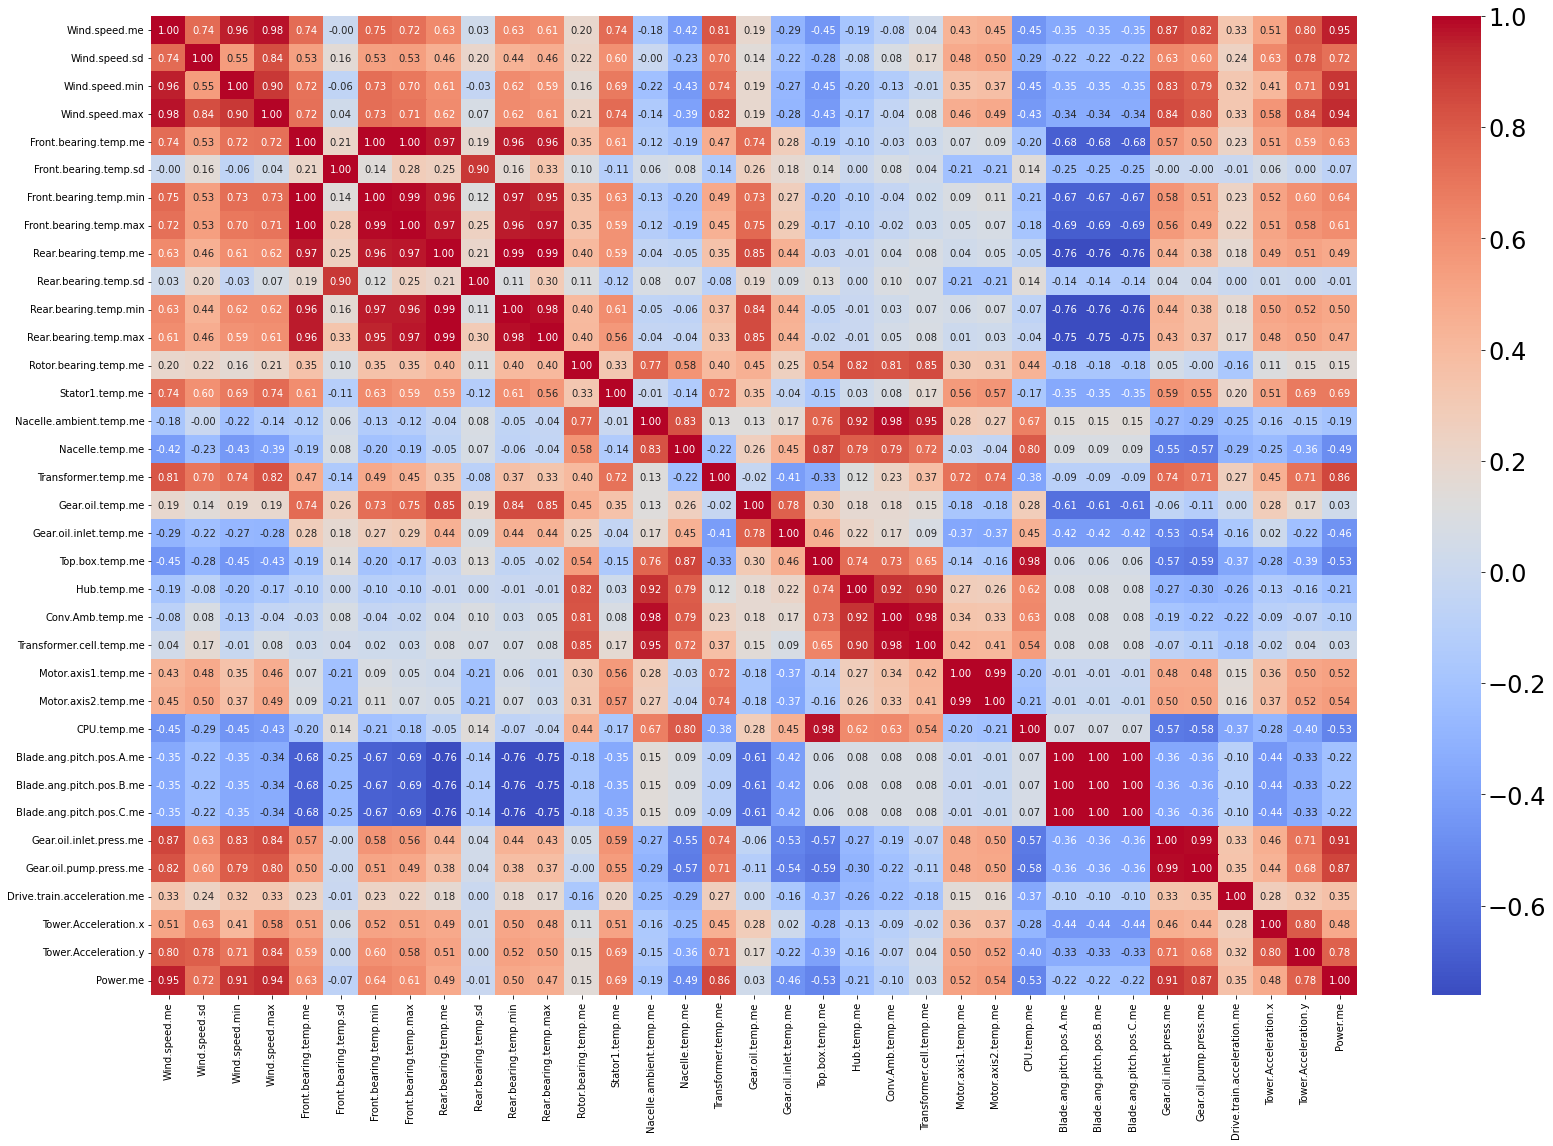

In [9]:
plt.figure(figsize=(27, 18))
correlation_matrix = df[features + [output_feature]].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

plt.show()

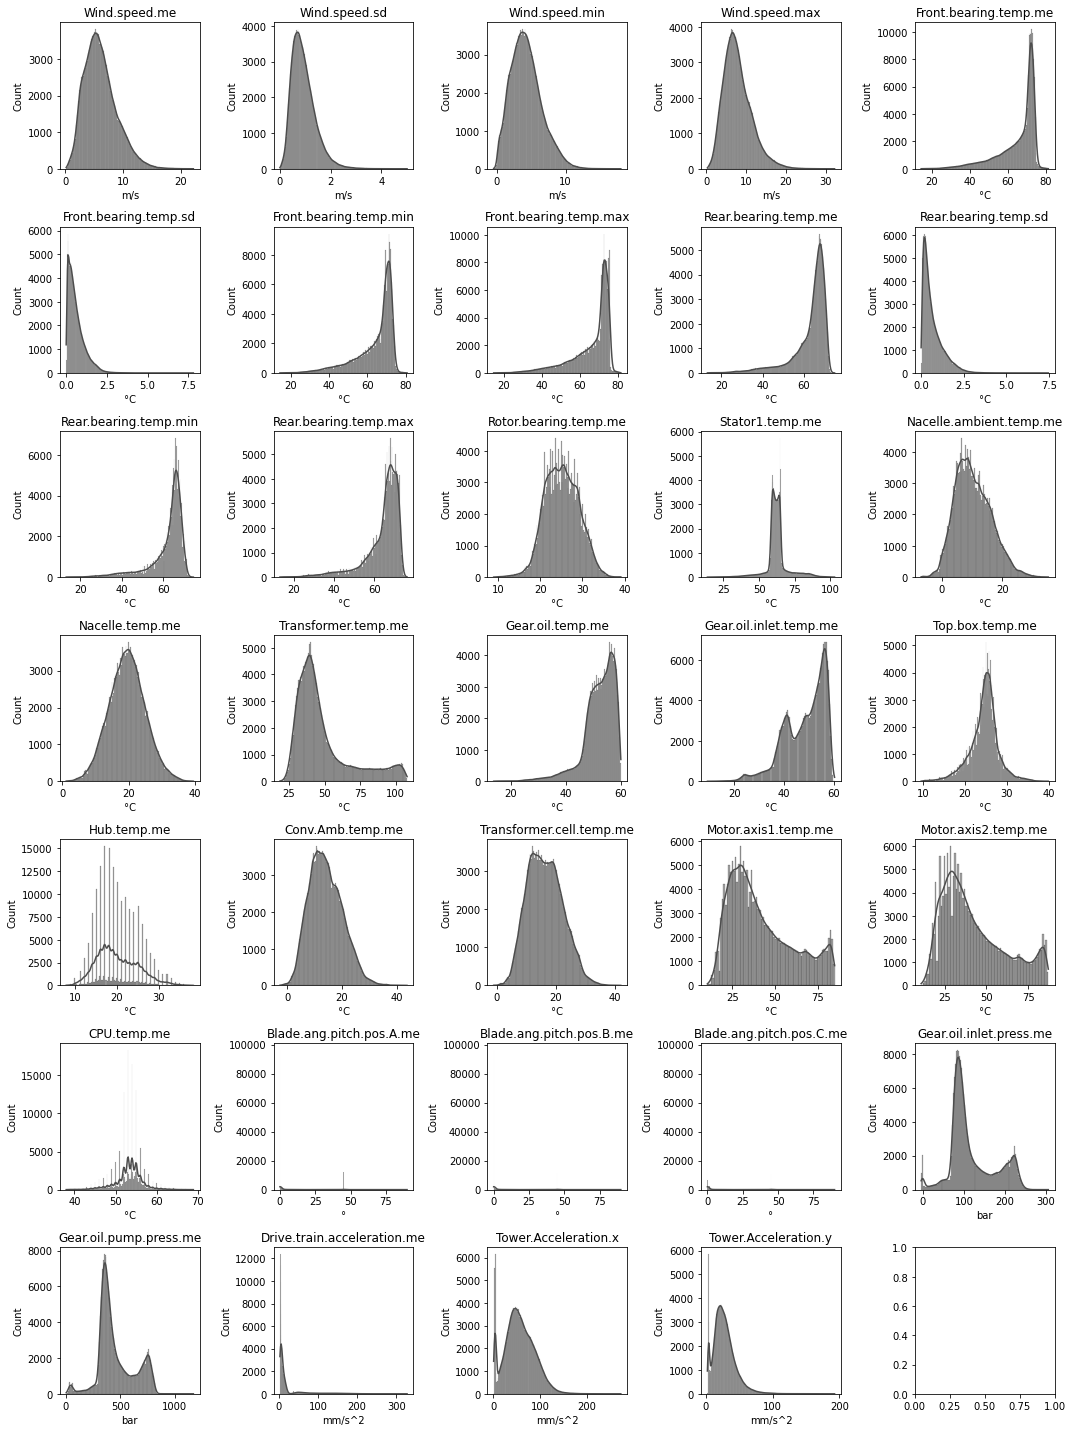

In [10]:
num_cols = 5
num_rows = math.ceil(len(features) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, ax=axes[i], color="0.3")
    axes[i].set_title(feature)
    axes[i].set_xlabel(units[feature])
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()

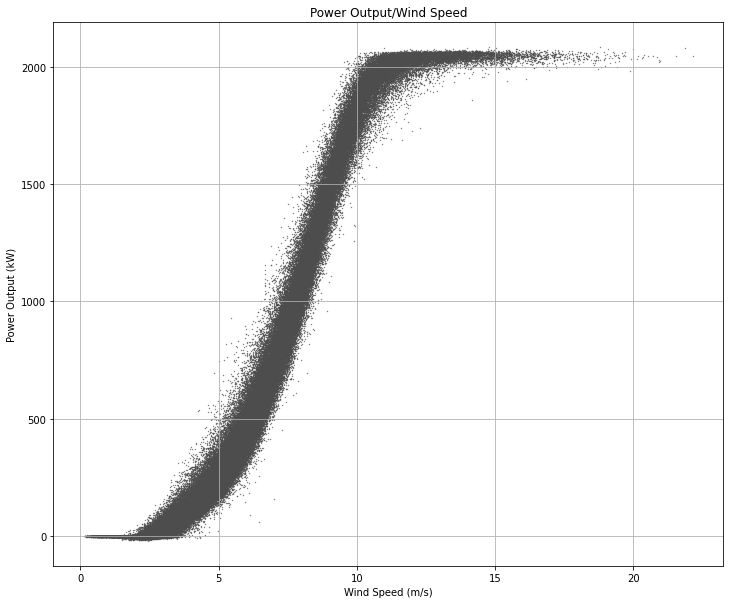

In [11]:
# Plot Power over Wind Speed
plt.figure(figsize=(12, 10))
plt.scatter(df['Wind.speed.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Wind Speed')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

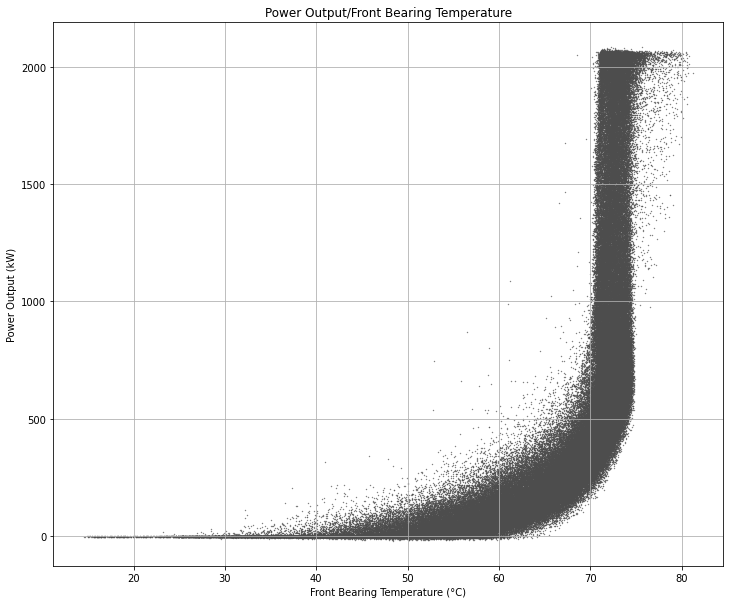

In [12]:
# Plot Power over Front Bearing Temperature
plt.figure(figsize=(12, 10))
plt.scatter(df['Front.bearing.temp.me'], df[output_feature], alpha = .7, color="0.3", linewidth = 0, s = 2)
plt.title('Power Output/Front Bearing Temperature')
plt.xlabel('Front Bearing Temperature (°C)')
plt.ylabel('Power Output (kW)')
plt.grid(True)
plt.show()

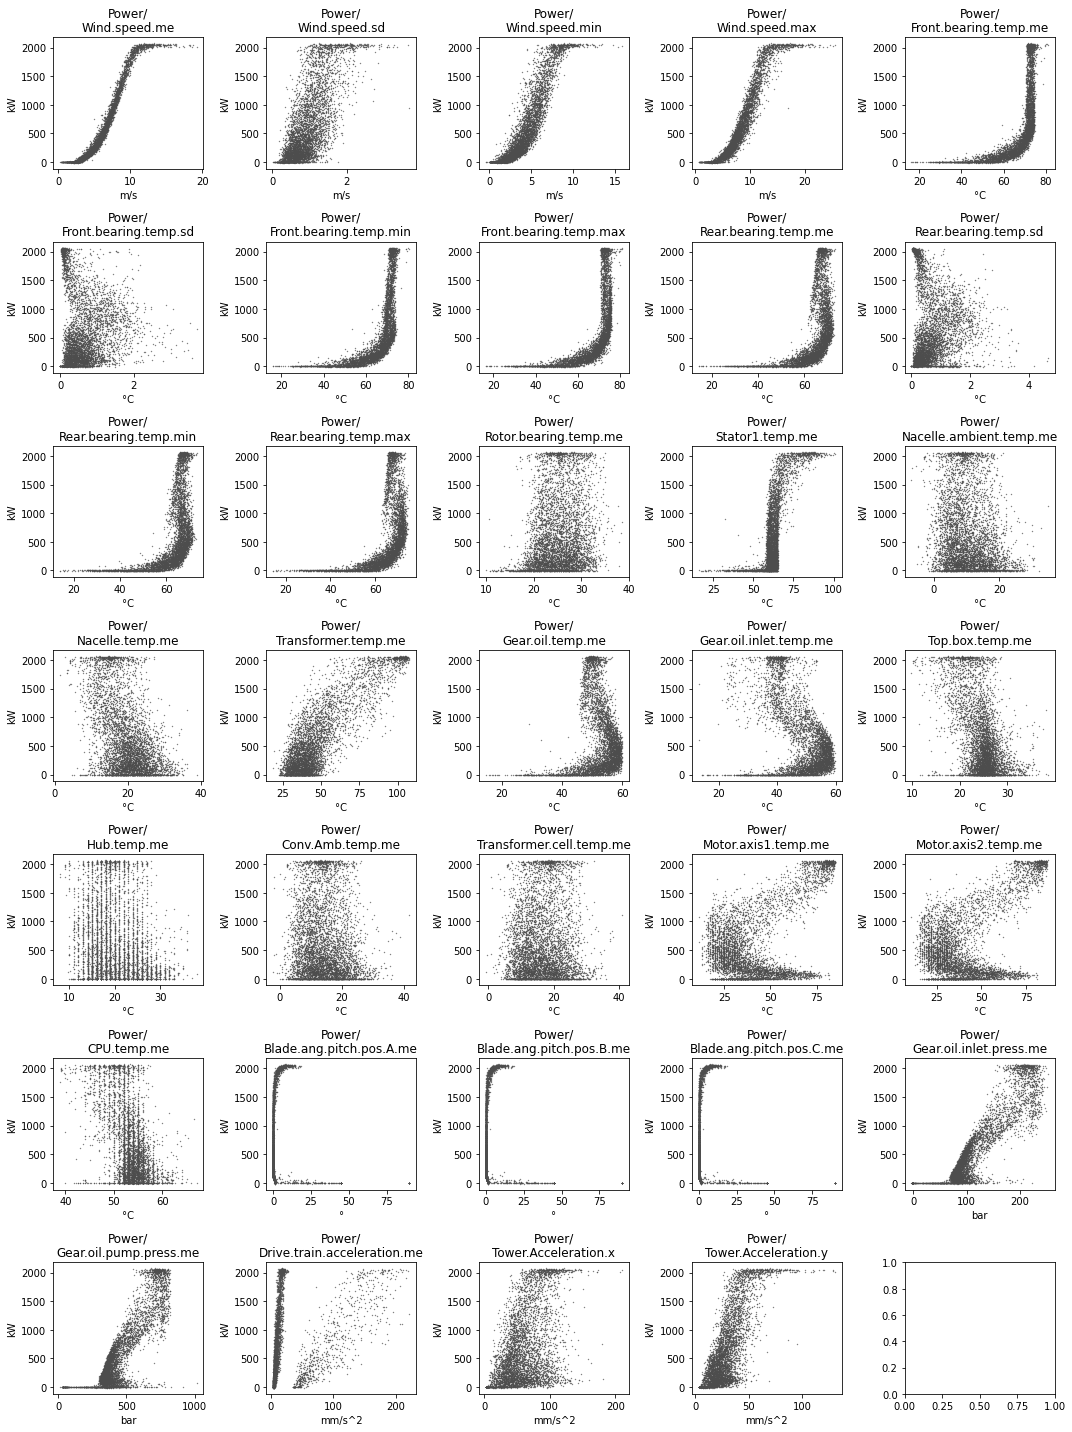

In [13]:
def plot_power_over_all_features(df, features, output_feature, sample_size=5000):
    df_sampled = df.sample(min(sample_size, len(df)))
    
    num_cols = 5
    num_rows = math.ceil(len(features) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        axes[i].scatter(x=df_sampled[feature], y=df_sampled[output_feature], alpha=0.7, color="0.3", linewidth=0, s=2)
        axes[i].set_title(f'Power/\n{feature}')
        axes[i].set_xlabel(units[feature])
        axes[i].set_ylabel('kW')

    plt.tight_layout()
    plt.show()
    
plot_power_over_all_features(df, features, output_feature, sample_size=5000)

These plots show, first of all, the non-linearity relationship between power output and operatioanl variables, and secondly, how the variance can significantly vary within features domains

In [14]:
X_train, X_test, y_train, y_test, scaler = load_dataset_train_test_split(df, features, output_feature)

In [15]:
X_train.shape

(151504, 34)

In [16]:
# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

In [128]:
# Set TRAIN to True if want to retrain the models
TRAIN = False

# Set EVALUATE_FEATURE_IMPORTANCE to True if want to evaluate the feature importance for the BNN model
EVALUATE_FEATURE_IMPORTANCE = False

In [18]:
results = {}

## Standard (Homoscedastic) Neural Networks

We develop a deterministic multilayer perceptron (MLP) that uses as a loss function the mean squared error (MSE). The use of MSE as the loss function requires the assumption that the noise is identically and independently distributed accross the domain. The 'identically distributed' assumtpion assumes that the variance of the noise is not a function of the input parameters. Because of this, the deterministic MLP proposed below only accounts for homoscedastic sources of aleatoric and epistemic. However, the amount of error expressed by the model cannot be explicitly divided into epistemic and aleatoric uncertainty as the model does not explicitly output a distribution but a prediction. Confidence intervals can be derived as a function by assuming a gaussian distribution centred in the output of the network and with variance approximated by the MSE.

In [130]:
def create_model_mlp_non_probabilistic(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    hidden = Dense(80, activation="relu")(inputs)
    hidden = Dense(50, activation="relu")(hidden)
    hidden = Dense(20, activation="relu")(hidden)
    output = Dense(1, activation="linear")(hidden) 

    model_mlp_non_probabilistic = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic.compile(Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model_mlp_non_probabilistic

model_mlp_non_probabilistic = create_model_mlp_non_probabilistic(X_train, MODELS_SEED)

In [131]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic.keras",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic,
                          X_train, y_train,
                          patience=10, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [132]:
model_mlp_non_probabilistic.load_weights("saved_models/model_mlp_non_probabilistic.keras")

In [133]:
model_mlp_non_probabilistic.evaluate(X_test, y_test)

1184/1184 [==============================] - 1s 920us/step - loss: 1989.0674


1989.0673828125

In [134]:
y_train_pred = np.array(model_mlp_non_probabilistic.predict(X_train)).ravel()
y_test_pred = np.array(model_mlp_non_probabilistic.predict(X_test)).ravel()

# We approximate the standard deviation of the assumed gaussian noise by using the RMSE of the prediction. This also assumes
# homoscedasticity nature of the noise.
y_train_stddevs = np.full(len(y_train_pred), np.sqrt(mean_squared_error(y_train, y_train_pred)))
y_test_stddevs = np.full(len(y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred)))

evaluate_and_print_metrics(results, "Non-probabilistic MLP",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

1184/1184 [==============================] - 1s 830us/step
Train RMSE: 44.695
Test RMSE: 44.599
Train MAE: 28.857
Test MAE: 28.857
Percentage of Train Data Points within 99.00% CI: 96.57%
Percentage of Test Data Points within 99.00% CI: 96.54%


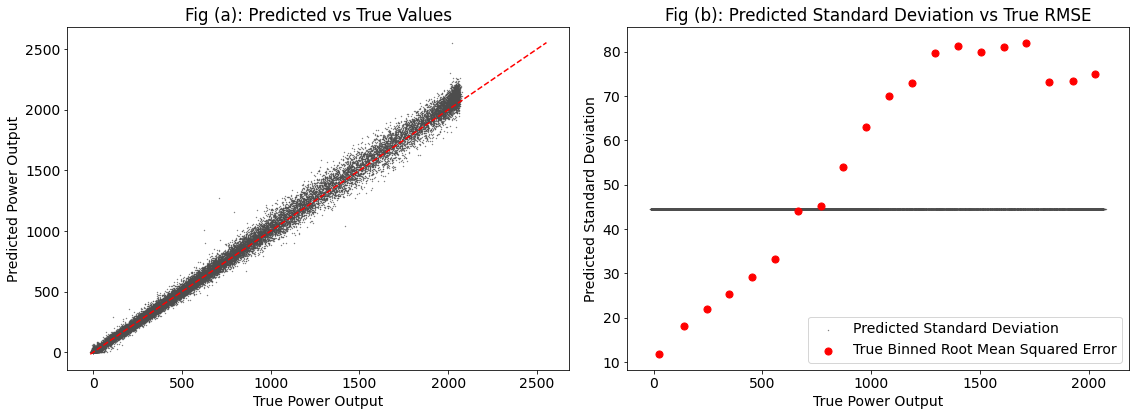

In [135]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

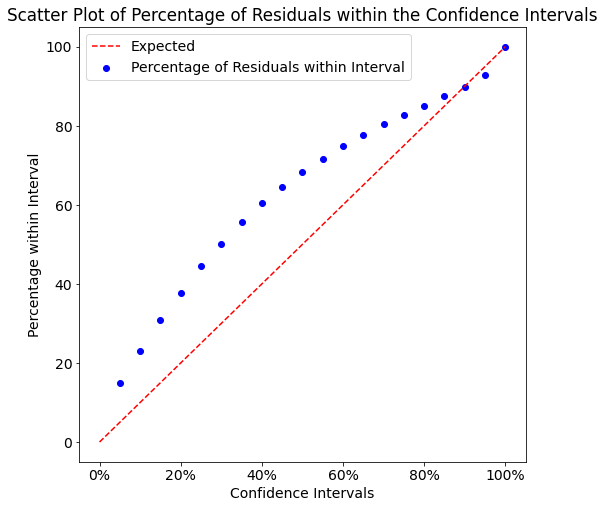

In [136]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

As you can see, althought the standard non-probabilistic neural network is an excellent approximator of the non linear relationship between SCADA variables and power output, as shown by the low RMSE, it is not a good model for evaluating uncertainty in prediction. It poorly overestimates uncertainty for power outputs, underestimates noise for mid-high power outputs, and again overestimates noise for the power outputs approaching 2000kW.

## Bayesian Neural Networks (Deterministic Output)

The purpose of introducing Bayesian Inference in neural networks is to introduce an estimation of the epistemic uncertainty (i.e., the uncertainty of the model - reducible with further training) of the model. In this framework, the model's weights are represented as posterior distributions instead of point-estimates. Therefore, as compared to traditional neural networks, the purpose of Bayesian Neural Network is to infere weight distributions from which an output given an input can be sampled. This represents the uncertainty of the model due to lack of data coverage. Typically, we expect epistemic uncertainty to be quite low for SCADA data sets as they provide large availability of data. 

BNN models are typically employed in data scarse systems, where identifying the uncertainty due to the lack of sufficient training is paramount. Because our dataset contains over 150,000 data entries, we expect low levels of epistemic uncertainty. This because it is possible to reduce epistemic uncertainty by giving the model sufficient representability capacity and train it over a sufficiently large dataset with respect to the number of model parameters. Nevertheless, we explore the use of BNN with deterministic output and probabilistic weights as a baseline model, and to show that most of the uncertainty in our regression task is given by irreducible noise and confirm that this is input-dependent. The models presented below leverage the approximate Bayesian Inference approach using Dense Flipout hidden layers. However, they have a non-probabilistic output, meaning it is unable to express heteroscedastic sources of aleatoric uncertainty. Again, because it minimizes the MSE, it assumes the data is distributed around an unknown function we are trying to approximate with an additive noise with homoscedastic variance.  

In particular, because of the higher computational complexity associated with BNNs as compared to standard neural networks, we have to reduce the size of our dataset to a 1% random sample.

In [137]:
SAMPLE_PERCENTAGE = 0.01
np.random.seed(MODELS_SEED)

sampled_indices = np.random.choice(len(X_train), int(len(X_train) * SAMPLE_PERCENTAGE), replace=False)
X_train_sampled = X_train[sampled_indices]
y_train_sampled = y_train[sampled_indices]

### Dense Flipout Layers (sample data set)

Below it is presented a Bayesian multilayer perceptron (MLP) which approximates bayesian inference using Variational Inference via Flipout [1]. We specify Normal distributions with trainable parameters as weights for all hidden layers. In this case, we have an heteroscedastic epistemic and homoscedastic aleatoric model. The heteroscedasticity nature of the represented model uncertainty is derived through the use of probability distributions as weights, while the noise is still modelled with fixed variance (aleatoric homoscedasticity) because the network has a deterministic output that minimizes the MSE (this is equivalent to Maximum A Posteriori estimation of a symmetric distribution).


[1] Wen, Y., Vicol, P., Ba, J., Tran, D., & Grosse, R. (2018). Flipout: Efficient Pseudo-Independent weight perturbations on Mini-Batches. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1803.04386

In [138]:
def create_model_mlp_non_probabilistic_bnn_flipout(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)
    
    output = tfp.layers.DenseFlipout(
            units=1,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            activation = "relu"
        )(hidden2)

    model_mlp_non_probabilistic_bnn = Model(inputs=inputs, outputs=output)
    model_mlp_non_probabilistic_bnn.compile(Adam(learning_rate=0.001), loss='mean_squared_error')

    return model_mlp_non_probabilistic_bnn

model_mlp_non_probabilistic_bnn_flipout_sample = create_model_mlp_non_probabilistic_bnn_flipout(X_train_sampled, MODELS_SEED)

C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\filip\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [139]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic_bnn_flipout_sample,
                          X_train_sampled, y_train_sampled,
                          patience=20, epochs=100, batch_size=256,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [140]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout_sample.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout_sample.keras")

In [141]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout_sample, X_train, X_test, num_samples=20)

4735/4735 [==============================] - 6s 1ms/step


KeyboardInterrupt: 

In [ ]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, f"Epistemic Uncertainty BNN (Flipout) - {SAMPLE_PERCENTAGE*100}% Sample", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

The RMSE of the of the model is high. We explore if this can be reduced with further training by considering the full training data set.

### Dense Flipout Layers (full data set)

An equivalent model as shown above, but trained over the full dataset. We show how further training can reduce epistemic uncertainty and decrease the prediction error of the model. However, we show how this is not fully representative of the uncertainty in the system, since most of the uncertainty is given by the variance of the noise, which we cannot model with a deterministic output.

In [ ]:
model_mlp_non_probabilistic_bnn_flipout = create_model_mlp_non_probabilistic_bnn_flipout(X_train, MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_non_probabilistic_bnn_flipout.keras",
                                                     save_weights_only=True,
                                                     verbose=0)

    history = train_model(model_mlp_non_probabilistic_bnn_flipout,
                          X_train, y_train,
                          patience=20, epochs=400, batch_size=256,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [ ]:
# Load the model weights
model_mlp_non_probabilistic_bnn_flipout.load_weights("saved_models/model_mlp_non_probabilistic_bnn_flipout.keras")

In [ ]:
model_mlp_non_probabilistic_bnn_flipout.evaluate(X_test, y_test)

In [ ]:
y_train_pred_mean, y_train_pred_stddevs, \
y_test_pred_mean, y_test_pred_stddevs = \
compute_predictions(model_mlp_non_probabilistic_bnn_flipout, X_train, X_test, num_samples=20)

In [ ]:
y_train_pred = y_train_pred_mean.ravel()
y_test_pred = y_test_pred_mean.ravel()

y_train_stddevs = y_train_pred_stddevs.ravel()
y_test_stddevs = y_test_pred_stddevs.ravel()

evaluate_and_print_metrics(results, "Epistemic Uncertainty BNN (Flipout)", y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

##### Feature Importance

For the interest of the field we evaluate the raw feature importance within the Bayesian network. Let's evaluate feature importance for the BNN with deterministic output. We do this only for the deterministic output because the RATE library does not support probabilistic regressions (see https://github.com/lorinanthony/RATE). To do so we retrain the model wrapped into a BNN_Regressor class from the RATE library.

In [ ]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    p = X_test.shape[1]

    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)

    layers = []

    layers.append(tfp.layers.DenseFlipout(
            units=30,
            input_shape=(p,),
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=30,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        ))

    layers.append(tfp.layers.DenseFlipout(
            units=1,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "linear"
        ))

    bnn = BNN_Regressor(layers, p=p)
    fit_history = bnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1,
                        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
                        verbose=0)

    sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
    X_test_sampled = X_train[sampled_indices]
    y_test_sampled = y_train[sampled_indices]

    ratings = RATE_BNN(bnn, X_test_sampled, n_workers=1)

    sampled_indices = np.random.choice(len(X_train), 10000, replace=False)
    X_test_sampled = X_train[sampled_indices]
    y_test_sampled = y_train[sampled_indices]

    rates = RATE_BNN(bnn, X_test_sampled, n_workers=1)
    feature_importance = {feature: rate for feature, rate in zip(features, list(rates[0]))}

In [ ]:
if EVALUATE_FEATURE_IMPORTANCE == True:
    features = list(feature_importance.keys())
    importance_values = list(feature_importance.values())

    plt.figure(figsize=(10, 12))
    plt.barh(features, importance_values, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')

    for i, importance in enumerate(importance_values):
        plt.text(importance, i, f'{importance*100:.2f}', va='center')

    plt.xlim(0, max(importance_values) + 0.02)
    plt.tight_layout()
    plt.show()

While the deterministic Bayesian deep model presents very low RMSE, it is a poor approximator of the overall uncertainty of the model. This because it can only express the intrinsic uncertainty of the model caused by insufficient training or lack of expressivity of the model. However, since the epistemic uncertainty is evaluated as very low, it appears that the prediction residuals of the model are mostly caused by noise, which we cannot fully model with a non-probabilistic output. Moreover, the epistemic uncertainty is estimated as independent of the output true values.

## Bayesian Neural Networks (Probabilistic Output)

We introduce a probabilistic output to a bayesian netwrok with the same number of layers as the previous but more hidden units. This way we model the output as a univariate distribution parametrized via a mean and a variance functions in the input space of the network. The loss becomes the negative log-likelihood of the identically and indipendently distributed data points. Where the distribution is a univariate Normal with a mean function and variance function paramettrized by the model.

### Dense Flipout + Gaussian Output

In [ ]:
def create_model_bnn(X_train, seed):
    keras.utils.set_random_seed(seed) 
    
    kl_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (X_train.shape[0] * 1.0)
        
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = tfp.layers.DenseFlipout(
            units=80,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(inputs)
    
    hidden2 = tfp.layers.DenseFlipout(
            units=50,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden1)
    
    hidden3 = tfp.layers.DenseFlipout(
            units=20,
            kernel_prior_fn = tfp.layers.default_mean_field_normal_fn(),
            kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn() ,
            kernel_divergence_fn = kl_divergence_fn,
            activation = "relu"
        )(hidden2)
    
    # Output Univariate Normal Probabilistic Layer
    dist_params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(dist_params)

    model_bnn = Model(inputs=inputs, outputs=dist)
    model_bnn.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_bnn

model_bnn = create_model_bnn(X_train, MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_bnn.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_bnn,
                          X_train, y_train,
                          patience=10, epochs=100, batch_size=256,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [ ]:
model_bnn.load_weights("saved_models/model_bnn.keras")

In [ ]:
model_bnn.evaluate(X_test, y_test)

In [ ]:
y_train_pred = np.array(model_bnn(X_train).mean()).ravel()
y_test_pred = np.array(model_bnn(X_test).mean()).ravel()

y_train_stddevs = np.array(model_bnn(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_bnn(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Aleatoric & Epistemic Uncertainty BNN (Flipout)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

## Non-Bayesian
We create a non-Bayesian deep model for the mean and the standard deviation of a Gaussian. 

### Deep Neural Network with Gaussian Output (Separate Submodels)

Two identical and parallel networks process the input data independently to estimate the mean and variance parameters. These two sub-models employ three hidden layers with ReLU activation functions to capture non-linearity in the system with increasing levels of abstraction. The final layers of these sub-models are merged into a single output layer with two units, one for the predicted mean and one for the predicted variance). The loss is the negative log-likelihood of the Normal parametrized by these sub-models. This means, that, although the two sub-models extract independent non-linear features, they are trained simultaneously to minimize a common loss. 

In [ ]:
def create_model_mlp_gaussian_separate(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    mean_h1 = Dense(80, activation="relu")(inputs)
    variance_h1 = Dense(80, activation="relu")(inputs)
    
    mean_h2 = Dense(50, activation="relu")(mean_h1)
    variance_h2 = Dense(50, activation="relu")(variance_h1)
    
    mean_h3 = Dense(20, activation="relu")(mean_h2)
    variance_h3 = Dense(20, activation="relu")(variance_h2)
    
    mean_h4 = Dense(20, activation="relu")(mean_h3)
    variance_h4 = Dense(20, activation="relu")(variance_h3)
    
    mean_out = Dense(1)(mean_h4)
    variance_out = Dense(1)(variance_h4)
    
    params = Concatenate()([mean_out, variance_out])
    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_separate = create_model_mlp_gaussian_separate(X_train, MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_separate.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_separate,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [ ]:
model_mlp_gaussian_separate.load_weights("saved_models/model_mlp_gaussian_separate.keras")

In [ ]:
model_mlp_gaussian_separate.evaluate(X_test, y_test)

In [ ]:
y_train_pred = np.array(model_mlp_gaussian_separate(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_separate(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_separate(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_separate(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Separate Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

### Deep Neural Network with Gaussian Output (Joint Submodels)

A shared deep feature extractor sub-model is followed by two shallow sub-models with a single hidden layer and a single-unit output layer respectively. The first shared sub-model extract non-linear features from the input space, and the separate models estimate mean and variance respectively using non-linear combinations of the features extracted by the shared sub-model. The two single-unit outputs of the mean and variance sub-models are concatenated to represent the parameters of a univariate Normal.

In [ ]:
def create_model_mlp_gaussian_joint(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    hidden1 = Dense(100, activation="relu")(inputs)
    hidden2 = Dense(80, activation="relu")(hidden1)
    hidden3 = Dense(40, activation="relu")(hidden2)
    
    mean_h1 = Dense(20, activation="relu")(hidden3)
    mean_out = Dense(1)(mean_h1)
    
    variance_h1 = Dense(20, activation="relu")(hidden3)
    variance_out = Dense(1)(variance_h1)
    
    params = Dense(2)(Concatenate()([mean_out, variance_out]))

    
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_mlp_gaussian_joint.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [ ]:
model_mlp_gaussian_joint.load_weights("saved_models/model_mlp_gaussian_joint.keras")

In [ ]:
model_mlp_gaussian_joint.evaluate(X_test, y_test)

In [ ]:
y_train_pred = np.array(model_mlp_gaussian_joint(X_train).mean()).ravel()
y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()

y_train_stddevs = np.array(model_mlp_gaussian_joint(X_train).stddev()).ravel()
y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian MLP with Gaussian Output (Joint Sub-models)",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

By comparing the two architecture it is clear that a separate set of features decreases the model's out-of-sample error. Therefore, the proposed model in the study is the first. 

Below are presented a set of model that have been tested as potential coompetitors to the finalized model above. They have been presented here as they represent more complicated ways of leveraging deep learning as a tool for normal behaviour modelling of wind turbines power curve. However, the increased complexity of the model did not who improvements in performance, therefore the simpler and more robust model presented above was chosen as th ebest candidate.

## Additional Models

### CNN with Gaussian Output

In light of a study conducted by et al. [2], we propose the use of a 1-D CNN to be used as an extractor of spatial features within out feature space. While this model is purely exploratory, we expect this not to excel, because of the almost non-existent spatial dependecy among features. In simpler terms, because CNNs capture spatial features, they are extremely dependent in the order of the features. In our case, the ordering of the features as little predictive significance, so the use of a convolution over the feature space of the input is not really empirically justified.

[2] Xiang, L., Wang, P., Yang, X., Hu, A., & Su, H. (2021). Fault de-
tection of wind turbine based on SCADA data analysis using CNN
and LSTM with an attention mechanism. Measurement, 175, 109094.
https://doi.org/10.1016/j.measurement.2021.109094

In [ ]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
def create_model_cnn_gaussian(X_train, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=(X_train_cnn.shape[1], 1))
    conv1d_layer = Conv1D(filters=32, kernel_size=5, activation='relu')(inputs)
    maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
    
    flatten_layer = Flatten()(maxpooling_layer)
 
    hidden1 = Dense(50, activation="relu")(flatten_layer)
    hidden2 = Dense(50, activation="relu")(hidden1)
    hidden3 = Dense(20, activation="relu")(hidden2)
    
    params = Dense(2)(hidden3)
    dist = tfp.layers.DistributionLambda(normal_softplus)(params) 

    model_cnn_gaussian = Model(inputs=inputs, outputs=dist)
    model_cnn_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)
    
    return model_cnn_gaussian

model_cnn_gaussian = create_model_cnn_gaussian(X_train_cnn, MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_cnn_gaussian.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    history = train_model(model_cnn_gaussian,
                          X_train_cnn, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

    plot_loss_history(history)

In [ ]:
model_cnn_gaussian.load_weights("saved_models/model_cnn_gaussian.keras")

In [ ]:
model_cnn_gaussian.evaluate(X_test_cnn, y_test)

In [ ]:
y_train_pred = np.array(model_cnn_gaussian(X_train_cnn).mean()).ravel()
y_test_pred = np.array(model_cnn_gaussian(X_test_cnn).mean()).ravel()

y_train_stddevs = np.array(model_cnn_gaussian(X_train_cnn).stddev()).ravel()
y_test_stddevs = np.array(model_cnn_gaussian(X_test_cnn).stddev()).ravel()

evaluate_and_print_metrics(results, "Non-Bayesian CNN with Gaussian Output",
                           y_train, y_test, y_train_pred, y_test_pred,
                           y_train_stddevs, y_test_stddevs, CONFIDENCE_INTERVAL)

In [ ]:
plot_means_variances(y_test, y_test_pred, y_test_stddevs)

In [ ]:
plot_confidence_interval_scatter(y_test_pred, y_test_stddevs, y_test, bins=20)

Clearly, the model is underperforming as compared to the MLP model with Normal output. This is probably the case because the features extracted by the Convolution layer have little significance. 

### Modelling Multiple Turbines: a Multivariate Experiment

We present below an experiment consisting of multi-turbine modelling. The reasoning motivating this research comes from studying and modelling the correlation between different turbines and investigating whether this can improve the predictive performance of the multivariate model. Below are presented deep networks with multivariate outputs for the 6 turbines. The output is a multivariate Gaussian of which we model the mean vector and lower triangular matrix of its Cholesky decomposition. In this case, the negative log likelihood is:

$$
\text{NLL}(\mu, \Sigma) = \sum_{i=1}^{n} -\frac{1}{2} \left[ d \cdot \log(2\pi) + \log\left(|(\Sigma(\mathbf{x}_i))|\right) + (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)})^T (\Sigma(\mathbf{x}_i))^{-1} (\mathbf{y}_i - \boldsymbol{\mu(\mathbf{x}_i)}) \right]
$$

In [ ]:
def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

In [ ]:
def train_multivariate_model(model, X_train, y_train, epochs, batch_size, patience, cp_callback):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    model.build(X_train.shape)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping, cp_callback]
    )

    return history

In [ ]:
# Specify the number of turbines to consider
turbine_num = 6

# Select the n turbines with the most common non-NaN data points
turbine_counts = df_full.groupby('turbine').apply(lambda x: x.notna().all(axis=1).sum())
turbine_ids = turbine_counts.nlargest(turbine_num).index.tolist()

df_top_n = df_full[df_full['turbine'].isin(turbine_ids)]
df_multivariate = flatten_dataframe(df_top_n, features, output_feature, DATETIME_COL)
df_multivariate.dropna(inplace=True)

In [ ]:
df_multivariate.head()

In [ ]:
output_feature_columns = [c for c in df_multivariate.columns if c.startswith(output_feature)]
feature_columns = list(set(df_multivariate.columns).difference(output_feature_columns))

X_train_mult, X_test_mult, y_train_mult, y_test_mult, scaler_x_mult = load_dataset_train_test_split(df_multivariate, feature_columns, output_feature_columns)
y_train_mult = np.array(y_train_mult)
y_test_mult = np.array(y_test_mult)

In [ ]:
print(X_train_mult.shape, y_train_mult.shape)

In [ ]:
# Number of turbines considered in the prediction
d = y_train_mult.shape[-1]
print("Number of turbines considered in the prediction: ", d)

#### Diagonal Covariance Matrix (Separate branches for separate turbines)

In this case, we investigate whether we can construct a model which is able to predict all means and variances simultaneously. In this simpler case we do not model covariances between turbines. 

In [ ]:
def create_model_multivariate_gaussian_only_diagonal(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    outs = []

    for i in range(d):
        
        h_means1 = Dense(50, activation='relu')(inputs)
        h_cov1 = Dense(50, activation='relu')(inputs)
    
        h_means2 = Dense(30, activation='relu')(h_means1)
        h_cov2 = Dense(30, activation='relu')(h_cov1)
    
        h_means3 = Dense(20, activation='relu')(h_means2)
        h_cov3 = Dense(20, activation='relu')(h_cov2)
        
        out = Dense(2)(Concatenate()([h_means3, h_cov3]))
        outs.append(out)

    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.01),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_only_diagonal = create_model_multivariate_gaussian_only_diagonal(d, (X_train_mult.shape[1],), MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_multivariate_gaussian_only_diagonal.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal,
                                       X_train_mult, y_train_mult,
                                       epochs=100, patience=10, batch_size=32,
                                       cp_callback=cp_callback)
    
    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_only_diagonal.load_weights("saved_models/model_multivariate_gaussian_only_diagonal.keras")

In [ ]:
model_multivariate_gaussian_only_diagonal.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_scatter(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

#### Diagonal Covariance Matrix (Common branches for separate turbines)

In [ ]:
def create_model_multivariate_gaussian_only_diagonal_common(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)
    
    outs = []
        
    h1 = Dense(100, activation='relu')(inputs)
    h2 = Dense(50, activation='relu')(h1)
    h3 = Dense(30, activation='relu')(h2)
    
    for i in range(d):
        out = Dense(2)(h3)
        outs.append(out)


    concatenated_outputs = Concatenate()(outs)
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_diagonal_normal_softplus(t[:, 0::2], t[:, 1::2], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.001),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_only_diagonal_common = create_model_multivariate_gaussian_only_diagonal_common(d, (X_train_mult.shape[1],), MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_multivariate_gaussian_only_diagonal.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_only_diagonal_common,
                                       X_train_mult, y_train_mult,
                                       epochs=100, patience=10, batch_size=32,
                                       cp_callback=cp_callback)
    
    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_only_diagonal_common.load_weights("saved_models/model_multivariate_gaussian_only_diagonal.keras")

In [ ]:
model_multivariate_gaussian_only_diagonal_common.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_only_diagonal_common(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Only Diagonal)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print(f"Turbine #{i+1} - RMSE: {sqrt(err)}")

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_scatter(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

#### Lower Triangular Cholesky Decomposed Covariance Matrix

In the model presented below we model the full covariance matrix of a gaussian distribution. In the world of real numbers, covariance matrices are symmetric and positive-definite. To enforce this we only parametrize a lower triangular matrix as part the Cholesky decomposition of the final full covariance matrix. Therefore, for $d$ turbines, we need $d$ output units for the predicted mean vector and $d(d-1)/2$ for the predicted covariance. So $d(d+1)/2$ in total.

In [ ]:
def create_model_multivariate_gaussian_with_covariance(d, input_size, seed):
    keras.utils.set_random_seed(seed)
    
    inputs = Input(shape=input_size)

    h1_mean = BatchNormalization()(Dense(150, activation='relu')(inputs))
    h2_mean = BatchNormalization()(Dense(70, activation='relu')(h1_mean))
    h3_mean = BatchNormalization()(Dense(50, activation='relu')(h2_mean))
    
    h1_cov = BatchNormalization()(Dense(150, activation='relu')(inputs))
    h2_cov = BatchNormalization()(Dense(70, activation='relu')(h1_cov))
    h3_cov = BatchNormalization()(Dense(50, activation='relu')(h2_cov))
    
    out_mean = Dense(d, activation='linear')(h3_mean)
    out_cov = Dense(tfp.layers.MultivariateNormalTriL.params_size(d) - d)(h3_cov)
    
    # Concatenate mean and lower triangular part of the covariance matrix
    concatenated_outputs = Concatenate()([out_mean, out_cov])
    
    # Define the distribution layer
    distribution_layer = tfp.layers.DistributionLambda(
        lambda t: multivariate_covariance_normal_softplus(t[:, :d], t[:, d:], d)
    )
    
    model = Model(inputs=inputs, outputs=distribution_layer(concatenated_outputs),
                  name="multivariate_gaussian_with_covariance")
    
    model.compile(Adam(learning_rate=0.001, clipnorm=100),
                  loss=NLL)
   
    return model

model_multivariate_gaussian_with_covariance = create_model_multivariate_gaussian_with_covariance(d, (X_train_mult.shape[1],), MODELS_SEED)

In [ ]:
if TRAIN == True:
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="saved_models/model_multivariate_gaussian_with_covariance.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
    
    history = train_model(model_multivariate_gaussian_with_covariance,
                                       X_train_mult, y_train_mult,
                                       epochs=100, patience=10, batch_size=32,
                                       cp_callback=cp_callback)

    plot_loss_history(history)

In [ ]:
model_multivariate_gaussian_with_covariance.load_weights("saved_models/model_multivariate_gaussian_with_covariance.keras")

In [ ]:
model_multivariate_gaussian_with_covariance.evaluate(X_test_mult, y_test_mult)

In [ ]:
y_train_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).mean())
y_test_mult_pred = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).mean())

y_train_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).stddev())
y_test_mult_stddevs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).stddev())

y_train_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_train_mult).covariance())
y_test_mult_covs = np.array(model_multivariate_gaussian_with_covariance(X_test_mult).covariance())

evaluate_and_print_metrics(results, "Non-Bayesian Multivariate (Lower Triangular Covariance Matrix)",
                           y_train_mult.ravel(), y_test_mult.ravel(),
                           y_train_mult_pred.ravel(), y_test_mult_pred.ravel(),
                           y_train_mult_stddevs.ravel(), y_test_mult_stddevs.ravel(),
                           CONFIDENCE_INTERVAL)

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    err = mean_squared_error(y_test_mult[:, i], y_test_mult_pred[:, i])
    print("turbine #", i+1, "- RMSE:", sqrt(err))

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:") 
    plot_means_variances(y_test_mult[:, i], y_test_mult_pred[:, i], y_test_mult_stddevs[:, i])

In [ ]:
for i in range(y_test_mult_pred.shape[1]):
    print(f"Turbine #{i+1}:")
    plot_confidence_interval_scatter(y_test_mult_pred[:, i], y_test_mult_stddevs[:, i], y_test_mult[:, i], bins=20)

While we acknowledge that these multivariate models do not perform as accurately as its univariate counterparts, the exploration of this multivariate study leads to believe that, with larger data sets and greater computational resources, larger probabilistic networks could be trained to perform a probabilistic deep learning multivariate normal behaviour modelling of the power output of entire wind farms. This is something that, to the author's knowledge, has never been achieved before. In particular the limited data set of 73k data points for a very large number of tunable parameters, for example more than 150k in the network modelling covariance, does not allow for sufficiently reduced predictive variance, quantified in the amount of variation of the target function when considering a different dataset, of the network given its large capacity. 

## Results

In [ ]:
# Print metric results for all trained models
for model_name, res in results.items():
    print("Model: ", model_name)
    for metric, value in res.items():
        print(f"{metric:50} {value}")
    print("\n")

### Deep Neural Network with Gaussian Output (Joint Submodels) - Averaged over Seeds

We average our proposed model over 5 different random seed for initializing the vector weight to show that our model is robust to the randomness of weight initialization. We demonstrate this by showing a very low standard deviation over the sample set.

In [ ]:
if False:
    rmses = []
    maes = []
    percentages = []
    NUM_SEED = 5

    for seed in range(NUM_SEED):
        model_mlp_gaussian_joint = create_model_mlp_gaussian_joint(X_train, seed)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"saved_models/model_mlp_gaussian_joint_{seed}.keras",
                                                     save_weights_only=True,
                                                     verbose=0)
        history = train_model(model_mlp_gaussian_joint,
                          X_train, y_train,
                          patience=15, epochs=100, batch_size=32,
                          cp_callback=cp_callback)

        z_value = stats.norm.ppf((1 + CONFIDENCE_INTERVAL) / 2)

        y_test_pred = np.array(model_mlp_gaussian_joint(X_test).mean()).ravel()
        y_test_stddevs = np.array(model_mlp_gaussian_joint(X_test).stddev()).ravel()

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = np.sqrt(mean_absolute_error(y_test, y_test_pred))

        test_lower_bound = y_test_pred - z_value * y_test_stddevs
        test_upper_bound = y_test_pred + z_value * y_test_stddevs

        test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))
        test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

        rmses.append(test_rmse)
        maes.append(test_mae)
        percentages.append(test_percentage_within_interval)
        
    

In [ ]:
if TRAIN == True:
    print(f"Mean of RMSEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of RMSEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of MAEs over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of MAEs over {NUM_SEED} seeds: {np.array(rmses).std()}")

    print(f"Mean of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).mean()}")
    print(f"Standard deviation of percentages in {CONFIDENCE_INTERVAL} C.I. over {NUM_SEED} seeds: {np.array(rmses).std()}")

As predicted, the RMSE is inline with what we had for a single seed, moreover, the standard deviation is very low. This shows how our model is robust to the randomness of the weight initialization.

## Plots